In [1]:
import numpy as np
import pandas as pd
import histogrammar as hg
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from scipy.stats import chi2, norm


In [4]:
%matplotlib inline

In [5]:
plt.rc('font', size=12)

In [6]:
# generate fake y and y_prob

In [7]:
np.random.seed(43)

In [151]:
nexp = 800
ngen = 10500

# generate 2 class dataset
X_gen, y_gen = make_classification(n_samples=nexp * ngen + 1000, n_classes=2, random_state=1, n_features=5)


In [152]:
X, X_truth = X_gen[:1_000], X_gen[1_000:]
y, y_truth = y_gen[:1_000], y_gen[1_000:]

In [153]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)


LogisticRegression()

In [154]:
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)

precision, recall, thresholds = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))


Logistic: f1=0.950 auc=0.984


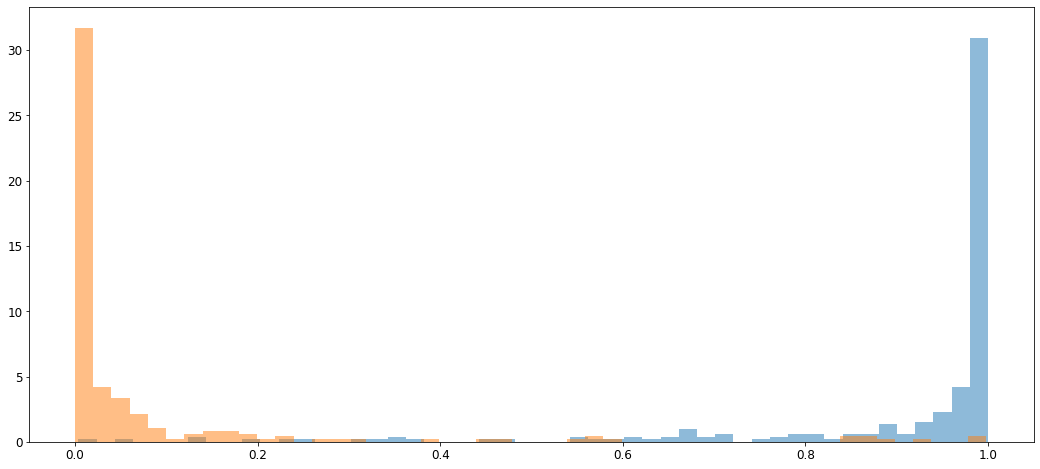

In [155]:
# plot the precision-recall curves
plt.figure(figsize=(18,8))
plt.hist(lr_probs[testy==1], bins=50, alpha=0.5, density=True);
plt.hist(lr_probs[testy==0], bins=50, alpha=0.5, density=True);


In [156]:
from tqdm import tqdm

In [157]:
y_avg1 = []
y_avg2 = []

for i in tqdm(range(nexp)):
    X_i = X_truth[ngen * i: ngen * (i+1)]
    y_i = y_truth[ngen * i: ngen * (i+1)]
    X_t, X_s = X_i[:500], X_i[500:]
    y_t = y_i[:500]
    lr_probs_s = model.predict_proba(X_s)[:, 1]
    lr_probs_t = model.predict_proba(X_t)[:, 1]
    #
    y_avg1.append( np.sum(y_t) / len(y_t) )
    y_avg2.append( np.sum(lr_probs_s) / len(lr_probs_s) - np.sum(lr_probs_t - y_t) / len(y_t) )
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 3057.76it/s]


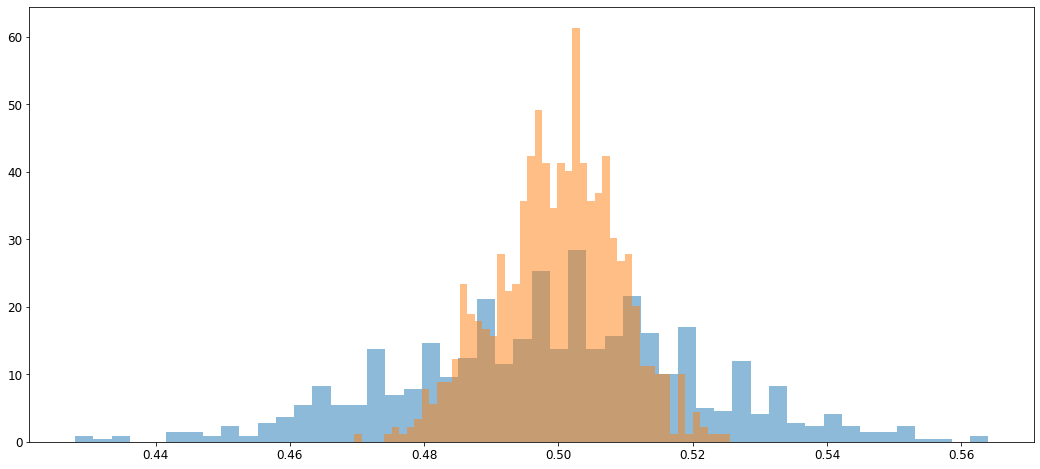

In [158]:
# plot the precision-recall curves
plt.figure(figsize=(18,8))
plt.hist(y_avg1, bins=50, alpha=0.5, density=True);
plt.hist(y_avg2, bins=50, alpha=0.5, density=True);

In [159]:
# standard deviations from distributions
np.std(y_avg1, ddof=1), np.std(y_avg2, ddof=1)

(0.022180833770023552, 0.009041221110951122)

In [160]:
# estimated standard deviation 1
e_orig = np.std(y_t, ddof=1) / np.sqrt(len(y_t))
e_orig

0.02237161098258039

In [161]:
# estimated standard deviation 1
e_l = np.std(lr_probs_s, ddof=1) / np.sqrt(len(lr_probs_s))
e_r = np.std(lr_probs_t - y_t, ddof=1) / np.sqrt(len(y_t))
e_l, e_r

(0.0045470207987539715, 0.008611111593794319)

In [162]:
e_total = np.sqrt(e_l**2 + e_r**2)
e_total

0.009737897156218079

In [163]:
# boost in test sample:

In [164]:
sample_factor = eorig**2 / e_total**2
sample_factor

5.283008387350354

In [167]:
y_avg1 = []
y_avg2 = []

threshold = 0.1

for i in tqdm(range(nexp)):
    X_i = X_truth[ngen * i: ngen * (i+1)]
    y_i = y_truth[ngen * i: ngen * (i+1)]
    X_t, X_s = X_i[:500], X_i[500:]
    y_t = y_i[:500]
    lr_probs_s = model.predict_proba(X_s)[:, 1]
    lr_probs_t = model.predict_proba(X_t)[:, 1]
    #
    
    ss_gt = lr_probs_s[lr_probs_s >= threshold]
    ts_gt = lr_probs_t[lr_probs_t >= threshold]
    ty_gt = y_t[lr_probs_t >= threshold]
    
    y_avg1.append( np.sum(ty_gt) / len(ty_gt) )
    y_avg2.append( np.sum(ss_gt) / len(ss_gt) - np.sum(ts_gt - ty_gt) / len(ty_gt) )
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 503.77it/s]


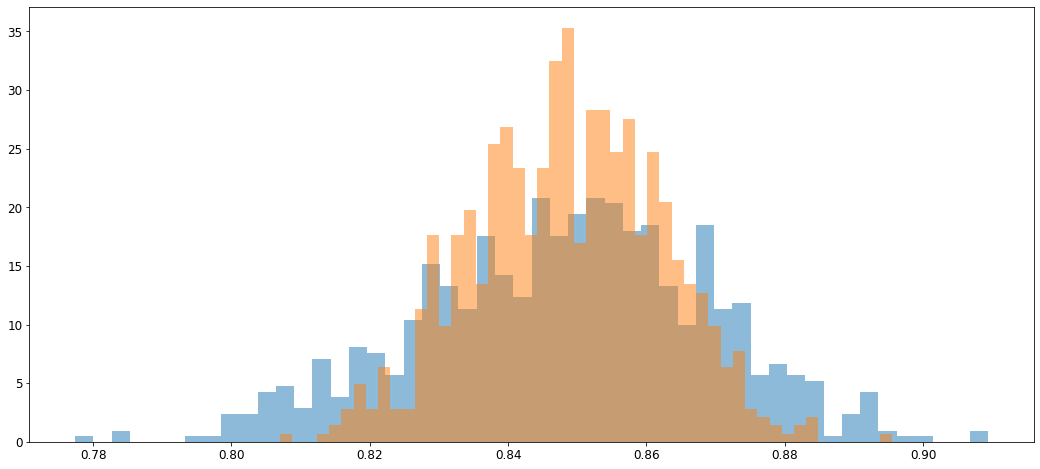

In [168]:
# plot the precision-recall curves
plt.figure(figsize=(18,8))
plt.hist(y_avg1, bins=50, alpha=0.5, density=True);
plt.hist(y_avg2, bins=50, alpha=0.5, density=True);